## Training a text classification model using noisy regular expressions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sklearn
import os

from sklearn.model_selection import train_test_split
from collections import Counter
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass, Context, Candidate, StableLabel
from snorkel.contrib.models.text import RawText
from snorkel.annotations import LabelAnnotator
from snorkel.learning import GenerativeModel
from snorkel.annotations import save_marginals
from snorkel.learning.tensorflow import TextRNN

### Download data if it doesn't exist

In [10]:
data_dir = "./data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    !curl https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD > ./data/complaints.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  720M    0  720M    0     0  7637k      0 --:--:--  0:01:36 --:--:-- 5567k


### Preprocessing
Data load, filtering out irrelevant fields and rows

Selects two types of products, for example, credit reporting and mortgage. 
Returns dataframe with complaint, and label - 1 = credit reporting complaints, -1 = other (mortgage)

In [4]:
complaints = pd.read_csv(os.path.join(data_dir,'complaints.csv'))
complaints.info()
complaints.shape

EmptyDataError: No columns to parse from file

Subset data to include products with narrative

In [4]:
products_w_narrative = complaints[complaints['Product'].notnull() & 
                                  complaints['Consumer complaint narrative'].notnull()]

In [5]:
print(products_w_narrative['Product'].unique())
print(products_w_narrative['Product'].value_counts())

['Debt collection'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Student loan' 'Credit card or prepaid card' 'Mortgage'
 'Money transfer, virtual currency, or money service'
 'Payday loan, title loan, or personal loan' 'Checking or savings account'
 'Vehicle loan or lease' 'Credit card' 'Bank account or service'
 'Credit reporting' 'Consumer Loan' 'Prepaid card' 'Payday loan'
 'Money transfers' 'Other financial service' 'Virtual currency']
Credit reporting, credit repair services, or other personal consumer reports    94174
Debt collection                                                                 87506
Mortgage                                                                        53334
Credit reporting                                                                31588
Student loan                                                                    21990
Credit card or prepaid card                                                     21787
Cred

In [6]:
# credit reporting only
credit_reporting = products_w_narrative[products_w_narrative['Product'] == 'Credit reporting, ' + 
                                 'credit repair services, or other personal consumer reports']
# mortgage only
mortgage = products_w_narrative[products_w_narrative['Product'] == 'Mortgage']

Combine into one dataframe, create labels (1 for credit reporting, -1 for mortgage)

In [7]:
credit_narrative = credit_reporting['Consumer complaint narrative'].values
positive_labels = pd.Series(np.ones(credit_narrative.shape[0]))
positive_df = pd.DataFrame({'complaint': credit_narrative, 'label': positive_labels})

In [8]:
mortgage_narrative = mortgage['Consumer complaint narrative'].values
negative_labels = pd.Series(np.full(mortgage_narrative.shape[0], -1))
negative_df = pd.DataFrame({'complaint': mortgage_narrative, 'label': negative_labels})

In [9]:
complaints_df = pd.concat([positive_df, negative_df], ignore_index=True)
complaints_df.shape

(147508, 2)

In [10]:
complaints_df['label'].value_counts()

 1.0    94174
-1.0    53334
Name: label, dtype: int64

In [11]:
# complaints_df = complaints_df.take(np.random.permutation(len(complaints_df))[:1000])
# complaints_df['label'].value_counts()

Split data into train, dev, test

In [12]:
train, testval = train_test_split(complaints_df, test_size=0.2, random_state=123)
dev, test = train_test_split(testval, test_size=0.5, random_state=123)

### Create noisy labeling functions

Regular expressions that define words, phrases, actions for use in labeling functions

In [13]:
POSITIVE_WORDS = r'\bcredit\b|\breport|\baddress\b|\bcreditor\b|\bexperian\b|\btransunion\b|\bequifax\b|\bfcra\b|\bcollector\b|\bdebt\b|\bconsumer\b'              
POSITIVE_PHRASE = r"\bcredit (report|agency|reporting|bureau|agencies)"
NEGATIVE_WORDS = r'\bloan\b|\bmortgage\b|\bhouse\b|\bhome\b|\bprepayment\b|\bappraise|\bforeclos\btax'
POSITIVE_ACTIONS = r'\bremov|\bdispute\b'
NEGATIVE_ACTIONS = r'\bpredator|\bmodifi\brefinanc'

FRAUD = r'\bfraudulent (account|charges)'
MONEYXFER = r'\bmoney transfer'
CREDIT_REPORTING = r'\b(identity has been compromise(|d)|data breaches|inquiries to businesses|mistakes appear in my report|reporting incorrectly|dispute(|d)|(t|T)ransunion|derogatory|experian|identity theft)'
CREDIT_REPAIR = r'\b(credit repair|hard inquiry|inquiries to businesses|mistakes appear in my report|reporting incorrectly)'

In [14]:
def lf_credit(complaint):
    if re.search(POSITIVE_WORDS, str(complaint), re.IGNORECASE):
        return 1
    else:
        return 0

def lf_credit_phrase(complaint):
    if re.search(POSITIVE_PHRASE, str(complaint), re.IGNORECASE):
        return 1
    else:
        return 0

def lf_credit_actions(complaint):
    if re.search(POSITIVE_ACTIONS, str(complaint), re.IGNORECASE):
        return 1
    else:
        return 0

def lf_mortgage(complaint):
    if re.search(NEGATIVE_WORDS, str(complaint), re.IGNORECASE):
        return -1
    else:
        return 0

def lf_mortgage_actions(complaint):
    if re.search(NEGATIVE_ACTIONS, str(complaint), re.IGNORECASE):
        return -1
    else:
        return 0
    
def lf_fraud(complaint):
    if (re.search(FRAUD, str(complaint), re.IGNORECASE)
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return 1
    elif (re.search(FRAUD, str(complaint), re.IGNORECASE) 
          and re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return -1
    else:
        return 0
    
def lf_reporting(complaint):
    if (re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE) 
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return 1
    elif (re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE) 
           and re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return -1
    else:
        return 0
    
def lf_repair(complaint):
    if (re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE) 
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE) 
        and not re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE)
       ):
        return 1
    elif ((re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE) 
           and re.search(MONEYXFER, str(complaint), re.IGNORECASE)) 
          or 
          (re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE) 
           and re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE))
         ):
        return -1
    else:
        return 0

### Generate Snorkel objects

#### Candidates

Candidate objects in Snorkel represent objects to be classified. In this case we are interested in classifying whether a narrative is positive - credit related or not.

In [15]:
session = SnorkelSession()

values = list(complaints_df.label.unique())
print(values)

# snorkel candidate, value if none defaults to binary (true, false)
Narrative = candidate_subclass('Narrative', ['narrative'], values=values)

# Make sure DB is cleared
session.query(Context).delete()
session.query(Candidate).delete()
session.query(StableLabel).delete()

[1.0, -1.0]


1000

#### Contexts

All Candidate objects point to one or more Context objects represent the raw data that they are rooted in. In this case, our candidates will each point to a single Context object representing the raw text of the complaint.

Once we have defined the Context for each Candidate, we can commit them to the database. Note that we also split into three sets while doing this:

- Training set (split=0): The narratives for which we have noisy, conflicting labels from our labeling functions; we will resolve these conflicts using the GenerativeModel and then use them as training data for the RNN
- Development set (split=1): We will pretend that we do not have any noisy, conflicting labels for this split of the data, and use these to test the RNN's performance on unseen data
- Test set (split=2): We will pretend that we do not have any noisy, conflicting labels for this split of the data, and use these to test the RNN's performance on unseen data    

Note: we also store the gold/ annotator labels available for future comparison


In [16]:
train_index = train.index
train.index.str = np.asarray(str(x) for x in train.index)
train_complaints = train.values[:, 0]
train_labels = train.values[:, 1]

for element in zip(train_index, train_complaints, train_labels):
    split = 0
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)
    context_stable_id = "~~".join([str(element[0]), str(element[0])])
    session.add(StableLabel(context_stable_ids=context_stable_id, 
                            annotator_name='gold',
                            split=0,
                            value=element[2]))
dev_index = dev.index
dev.index.str = np.asarray(str(x) for x in dev.index)
dev_complaints = dev.values[:, 0]
dev_labels = dev.values[:, 1]

for element in zip(dev_index, dev_complaints, dev_labels):
    split = 1
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)
    context_stable_id = "~~".join([str(element[0]), str(element[0])])
    session.add(StableLabel(context_stable_ids=context_stable_id, 
                            annotator_name='gold',
                            split=1,
                            value=element[2]))

test_index = test.index
test.index.str = np.asarray(str(x) for x in test.index)
test_complaints = test.values[:, 0]
test_labels = test.values[:, 1]

for element in zip(test_index, test_complaints, test_labels):
    split = 2
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)
    context_stable_id = "~~".join([str(element[0]), str(element[0])])
    session.add(StableLabel(context_stable_ids=context_stable_id, 
                            annotator_name='gold',
                            split=2,
                            value=element[2]))

session.commit()

# number of datapoints
print(session.query(Narrative).count())
# load ground truth labels
train_cand_labels = train_labels
dev_cand_labels = dev_labels
test_cand_labels = test_labels

147508


In [17]:
# test one labeling function
labeled = []
for c in session.query(Narrative).filter(Narrative.split == 1).all():
    if lf_credit(c) != 0:
        labeled.append(c)
print("Number labeled:", len(labeled))    

Number labeled: 11028


#### Labels

Next, we assign labeling functions for each of the training candidates in a sparse matrix (which will also automatically be saved to the Snorkel database), with one row for each candidate and one column for each label

In [18]:
LFs = [lf_credit, lf_credit_phrase, lf_credit_actions, lf_mortgage, lf_mortgage_actions, lf_fraud, lf_reporting, lf_repair]
# apply labeling functions
labeler = LabelAnnotator(lfs = LFs)
L_train = labeler.apply(split=0)

Clearing existing...


  0%|          | 35/118006 [00:00<05:37, 349.33it/s]

Running UDF...


100%|██████████| 118006/118006 [05:12<00:00, 377.81it/s]


In [19]:
# see what's going on
print(L_train.get_candidate(session, 0))
print(L_train.get_key(session, 0))
print(L_train.lf_stats(session))

Narrative(Raw Text XXXX XXXX XXXX- XX-XX-2016 Experian XXXX XXXX XXXX -XX/XX/2016 XXXX XXXX XXXX-XX/XX/2016 XXXX XXXX XXXX-XX/XX/2016 The inquiries that I have written above are unauthorized. I did not allow anyone to use my personal information to obtain goods. Experian and XXXX have not removed the fraud inquiries from my credit report even though i have disputed them multiple times.)
LabelKey (lf_credit)
                     j  Coverage  Overlaps  Conflicts
lf_credit            0  0.751606  0.674652   0.273452
lf_credit_phrase     1  0.437503  0.437503   0.128214
lf_credit_actions    2  0.328822  0.322585   0.099020
lf_mortgage          3  0.456155  0.282037   0.277833
lf_mortgage_actions  4  0.011440  0.011347   0.007144
lf_fraud             5  0.020448  0.020143   0.003127
lf_reporting         6  0.322128  0.319111   0.086097
lf_repair            7  0.027456  0.026846   0.018194


### Training generative model

Check if it assumes that the LFs have no dependencies by default?

In [20]:
gen_model = GenerativeModel()
gen_model.train(L_train, epochs=20, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


### Applying the generative model

#### Probabilistic Label Statistics
We view the distribution of weak labels produced by our generative model.

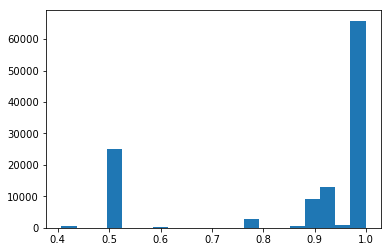

In [21]:
train_marginals = gen_model.marginals(L_train)
plt.hist(train_marginals, bins=20)
plt.show()

### Compare learned accuracies vs empirical accuracies
Learned accuracies from our generative model

In [22]:
accuracy = gen_model.score(L_train, train_cand_labels)
accuracy[0]
print("precision: {:.5f}".format(accuracy[0]), "recall: {:.5f}".format(accuracy[1]), 
      "F-beta: {:.5f}".format(accuracy[2]))

precision: 0.64624 recall: 0.96901 F-beta: 0.77537


Empirical accuracies of our labeling functions - majority vote. Also calculating precision, recall and f-beta for comparison

In [23]:
# Collect the majority vote answer for each complaint
mv = []
for i in range(L_train.shape[0]):
    if np.diff(L_train[i].indptr) != 0:   #indicates that there is no coverage for a particular datapoint
        c = Counter([L_train[i,j] for j in L_train[i].nonzero()[1]])
        #print(c)
        mv.append(c.most_common(1)[0][0])
        #print(c.most_common(1)[0][0])
    else:
        mv.append(-1) # assume that no label is equivalent to a negative example

mv = np.array(mv)

# Count the number correct by majority vote
n_correct = np.sum([1 for i in range(L_train.shape[0]) if mv[i] == train_cand_labels[i]])
print ("Accuracy:{}".format(n_correct / float(L_train.shape[0])))
print ("Number incorrect:{}".format(L_train.shape[0] - n_correct))

# Compute and return precision, recall, and F1 score
tp = (0.5 * (mv * train_cand_labels + 1))[mv == 1].sum()
pred_pos = mv[mv == 1].sum()
p = tp / float(pred_pos) if pred_pos > 0 else 0.0
pos = train_cand_labels[train_cand_labels == 1].sum()
r = tp / float(pos) if pos > 0 else 0.0

# Compute general F-beta score
beta=1
if p + r > 0:
    f_beta = (1 + beta**2) * ((p * r) / (((beta**2) * p) + r))
else:
    f_beta = 0.0
p, r, f_beta
print("precision: {:.5f}".format(p), "recall: {:.5f}".format(r), "F-beta: {:.5f}".format(f_beta))

Accuracy:0.8135772757317424
Number incorrect:21999
precision: 0.79070 recall: 0.96268 F-beta: 0.86826


We can also get a more detailed score (true positives, false positives, true negatives, false negatives) on the dev set

In [24]:
L_dev = labeler.apply(split=1)
# score it
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, dev_cand_labels)

Clearing existing...


  0%|          | 34/14751 [00:00<00:43, 334.59it/s]

Running UDF...


100%|██████████| 14751/14751 [00:37<00:00, 389.12it/s]


Scores (Un-adjusted)
Pos. class accuracy: 0.966
Neg. class accuracy: 0.0648
Precision            0.646
Recall               0.966
F1                   0.774
----------------------------------------
TP: 9094 | FP: 4992 | TN: 346 | FN: 319



Save the predictions of the generative model on the train and test set back to the database

In [25]:
save_marginals(session, L_train, train_marginals)

Saved 118006 marginals


### Training a ML model based on the probabilistic labels

First, load the candidates

In [26]:
train_cands = session.query(Narrative).filter(Narrative.split == 0).order_by(Narrative.id).all()
dev_cands   = session.query(Narrative).filter(Narrative.split == 1).order_by(Narrative.id).all()
test_cands  = session.query(Narrative).filter(Narrative.split == 2).order_by(Narrative.id).all()

Note how the number of training samples are lower than what's present in the training set, it excludes samples where there was no LF coverage (train_marginals.shape[0] - (train_marginals == 0.5).sum())

In [28]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   100,
    'dropout':    0.2,
    'print_freq': 5,
    'seed': 123,
    'batch_size': 10
}

lstm = TextRNN(seed=123, cardinality=Narrative.cardinality)
# Note: Y_train are the marginals but Y_dev are the gold/ ground truth labels
lstm.train(X_train=train_cands, Y_train=train_marginals, X_dev=dev_cands, Y_dev=dev_cand_labels, **train_kwargs)

[TextRNN] Training model
[TextRNN] n_train=113422  #epochs=100  batch size=10


ResourceExhaustedError: OOM when allocating tensor with shape[10,5729,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node embedding_lookup (defined at /home/nisha/snorkel/snorkel/learning/tensorflow/rnn/rnn_base.py:81) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node Mean (defined at /home/nisha/snorkel/snorkel/learning/tensorflow/noise_aware_model.py:77) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'embedding_lookup', defined at:
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-b444b3385591>", line 13, in <module>
    lstm.train(X_train=train_cands, Y_train=train_marginals, X_dev=dev_cands, Y_dev=dev_cand_labels, **train_kwargs)
  File "/home/nisha/snorkel/snorkel/learning/tensorflow/rnn/rnn_base.py", line 173, in train
    word_dict=self.word_dict, max_len=max_len, **kwargs)
  File "/home/nisha/snorkel/snorkel/learning/tensorflow/noise_aware_model.py", line 206, in train
    self._build_new_graph_session(**kwargs)
  File "/home/nisha/snorkel/snorkel/learning/tensorflow/noise_aware_model.py", line 117, in _build_new_graph_session
    self._build_model(**model_kwargs)
  File "/home/nisha/snorkel/snorkel/learning/tensorflow/rnn/rnn_base.py", line 81, in _build_model
    inputs = tf.nn.embedding_lookup(embedding, self.sentences)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/ops/embedding_ops.py", line 316, in embedding_lookup
    transform_fn=None)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/ops/embedding_ops.py", line 133, in _embedding_lookup_and_transform
    result = _clip(array_ops.gather(params[0], ids, name=name),
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 3273, in gather
    return gen_array_ops.gather_v2(params, indices, axis, name=name)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3748, in gather_v2
    "GatherV2", params=params, indices=indices, axis=axis, name=name)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/nisha/anaconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10,5729,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node embedding_lookup (defined at /home/nisha/snorkel/snorkel/learning/tensorflow/rnn/rnn_base.py:81) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node Mean (defined at /home/nisha/snorkel/snorkel/learning/tensorflow/noise_aware_model.py:77) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
accuracy_dev = lstm.score(dev_cands, dev_cand_labels)
print("precision: {:.5f}".format(accuracy_dev[0]), "recall: {:.5f}".format(accuracy_dev[1]), 
      "F-beta: {:.5f}".format(accuracy_dev[2]))

In [ ]:
accuracy_test = lstm.score(test_cands, test_cand_labels)
print("precision: {:.5f}".format(accuracy_test[0]), "recall: {:.5f}".format(accuracy_test[1]), 
      "F-beta: {:.5f}".format(accuracy_test[2]))